<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> # Earth Satellites
>
> Skyfield is able to predict the positions of Earth satellites by loading satellite orbital elements from Two-Line Element (TLE) files — published by organizations like CelesTrak — and running them through the SGP4 satellite propagation routine. 

## TLE file format:
>AAAAAAAAAAAAAAAAAAAAAAAA

>1 NNNNNU NNNNNAAA NNNNN.NNNNNNNN +.NNNNNNNN +NNNNN-N +NNNNN-N N NNNNN

>2 NNNNN NNN.NNNN NNN.NNNN NNNNNNN NNN.NNNN NNN.NNNN NN.NNNNNNNNNNNNNN

- Line 0:  corresponds to the Satelletie catalog number (NORAD SATCAT) = (the name of the satellite)
- Line 1:

Reference : https://celestrak.com/NORAD/documentation/tle-fmt.php

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from skyfield.api import load, wgs84

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE file
>
> Skyfield loader objects offer a tle_file() method that can download and cache a file full of satellite elements from a site like Celestrak. A popular observing target for satellite observers is the International Space Station, which is listed in Celestrak’s stations.txt file:

In [22]:
# stations_url = 'https://www.celestrak.com/NORAD/elements/geo.txt' # Retrieve geo satellite from celestrak
stations_url = 'https://celestrak.com/NORAD/elements/weather.txt' # Retrieve weather satellites


satellites = load.tle_file(stations_url, reload=False)

by_name = {sat.name: sat for sat in satellites}
satellite = by_name['METOP-B']

print(satellite)

METOP-B catalog #38771 epoch 2021-12-11 04:46:27 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
    
> ## Loading a TLE set from strings
> If your program already has the two lines of TLE data for a satellite and doesn’t need Skyfield to download and parse a Celestrak file, you can instantiate an EarthSatellite directly.

In [7]:
from skyfield.api import EarthSatellite

ts = load.timescale()
#line1 = '1 38771U 12049A   21328.15653177  .00000019  00000+0  28851-4 0  9990'
#line2 = '2 38771  98.6954  26.0543 0000110 196.3188 189.2859 14.21494351476561'
#line1 = '1 38771U 12049A   21345.19892716  .00000005  00000+0  22412-4 0  9999'
#line2 = '2 38771  98.6932  42.8377 0000999 161.9725 266.8848 14.21496788478982'

#satellite = EarthSatellite(line1, line2, 'METOP-A', ts)

#print(ts)
#print(satellite)

METOP-B catalog #38771 epoch 2021-12-11 04:46:27 UTC


<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Satellite altitude, azimuth, and distance
>
> You might be most interested in whether the satellite is above or below the horizon from your own position as an observer, and in which direction to look for it. If you build an object to represent your latitude and longitude , you can use vector subtraction to ask “where will the satellite be relative to my location?”

(527041,)
100000
200000
300000
400000
500000


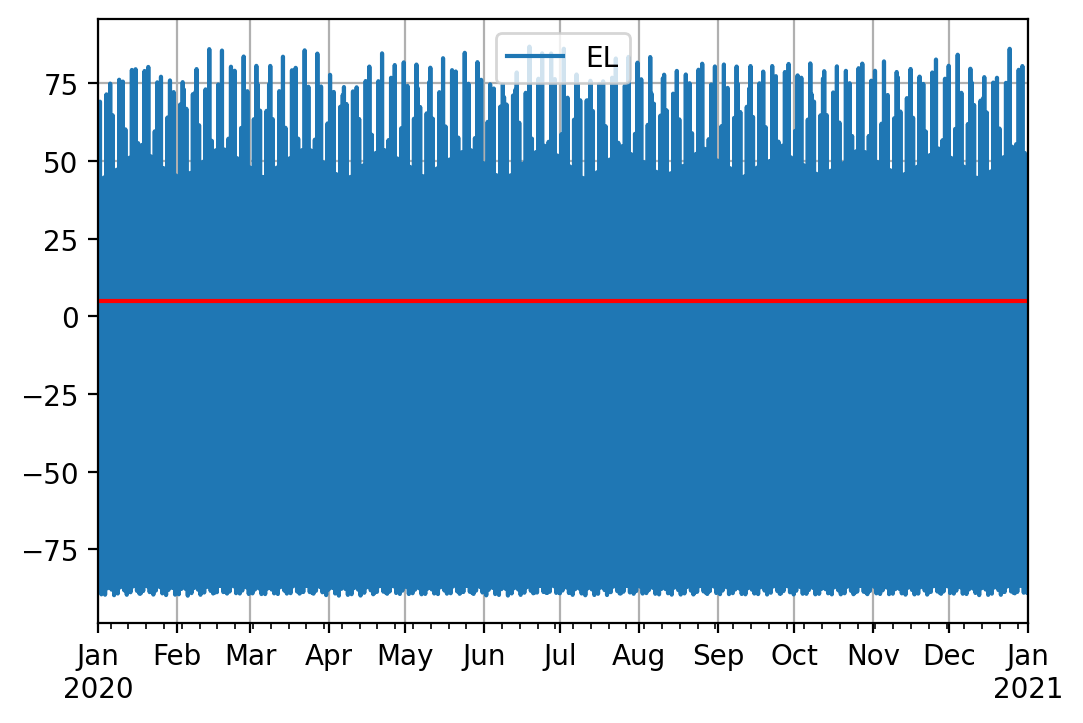

In [23]:

Lavrion = wgs84.latlon(37.72, 24.048)

difference = satellite - Lavrion

dates = pd.date_range("2020-01-01","2021-01-1",freq='60S')
alt = np.zeros(np.size(dates)) * np.nan
az = np.zeros(np.size(dates)) * np.nan
print(dates.shape)
count = 0

for ii,date in enumerate(dates):
    count+=1
    if (count%100000==0) :
        print(count)
    t = ts.utc(date.year, date.month, date.day, date.hour, date.minute, date.second)

    topocentric = difference.at(t)

    alt_, az_, distance = topocentric.altaz()

    alt[ii] = alt_.degrees
    az[ii] = az_.degrees

df = pd.DataFrame(index = dates)

# ind = np.nonzero(alt<5)

# alt[ind] = np.nan
# az[ind] = np.nan 

df['EL'] = alt 
df['AZ'] = az 

Plot = True
if Plot:
    fig, ax = plt.subplots(dpi=200)
    ax = df.plot(ax=ax, y='EL', linestyle='solid', marker='')

    ax.grid(b=True, which='major', axis='both')
    ax.axhline(y=5, color='r', linestyle='-')

    plt.show()

<style>
    h1 {font-family:Times; font-size:20pt}
    h2 {font-family:Times; font-size:18pt}
    h3 {font-family:Times; font-size:16pt}
    p {font-family:Times; font-size:12pt}
    </style>
>
> ## Probability density function
>
> In this section the probability density function for elevation angle will be calculated $P(\theta)$

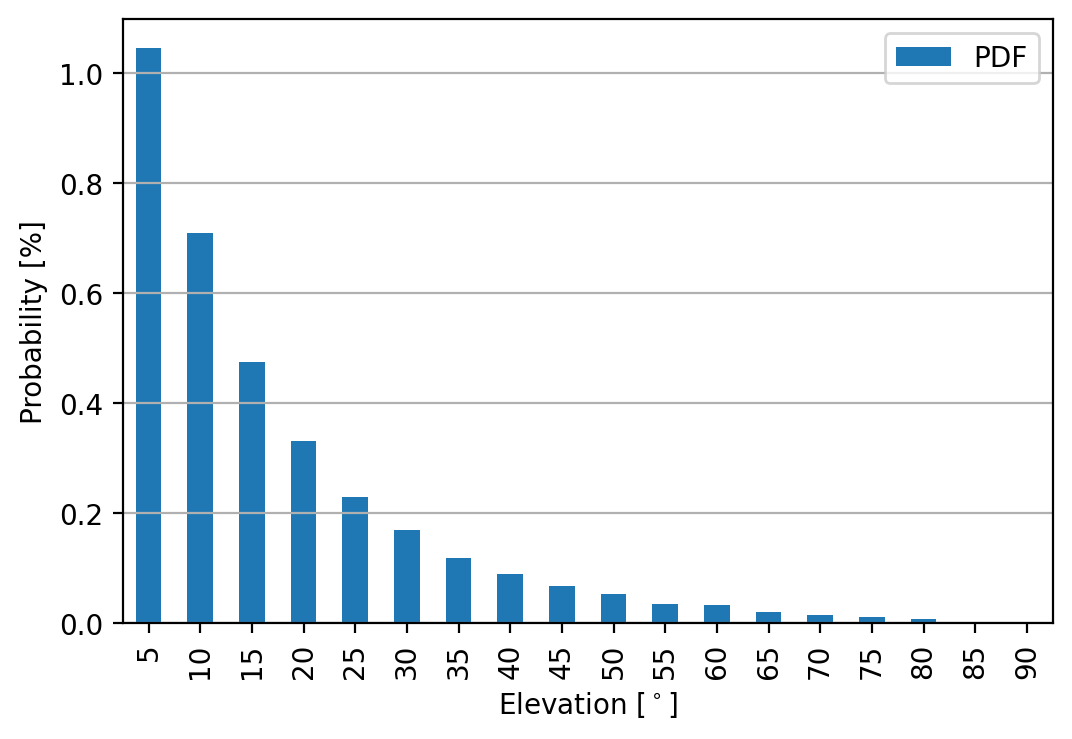

In [83]:

stp = 5
bins = np.arange(5,91,stp) # Regroup in block of 5°, threshold 

stat = pd.DataFrame(index=bins)


for bin in bins:
    ind  = np.logical_and( bin <= df['EL'] , df['EL'] < bin+stp) # For all elevation that are in the range bin, bin+stp

    el = df.loc[ind,'EL'] # Select all elevation that are in the current bin, bin+stp range

    stat.loc[bin,'PDF'] = np.size(el)/np.size(ind) * 100 # Probability of presensce in the current bin: PDF = (#number of element in the current bin)/(#number total number of element)

# Save pdf to pickle
stat.to_pickle("./pdf_Lavrion.pkl")

fig, ax = plt.subplots(dpi=200)
ax = stat.plot(ax=ax, y='PDF', kind='bar')
ax.grid(b=True, which='major', axis='y')

ax.set_xlabel(r'Elevation [$^\circ$]')
ax.set_ylabel(r'Probability [%]')
plt.show()



# Compute average of attenuation
## Loading data 

In [146]:

folders_name = ["Lavrion-37.5GHz-5-50", "Lavrion-37.5GHz-55-89.9", "Lavrion-75GHz-5-50", "Lavrion-75-GHz-55-89.9", "Ljubljana-37.5GHz-5-50", "Ljubljana-37.5GHZ-55-89.9", "Ljubljana-75GHz-5-50", "Ljubljana-75GHz-55-89.9"]

attenuations_file = {'total': "attenuation_total.csv", "cloud": "attenuation_cloud.csv", "oxygen":"attenuation_oxygen.csv", "rain":"attenuation_rain.csv", "scintillation":"attenuation_scintillation.csv"}
att_columns = {'total':'att_comb_dB', 'cloud':'att_cld_dB', 'oxygen':'', 'rain':'att_rain_dB', 'scintillation':''}

selected_attenuation = 'rain' ## Change here to select another atenuation

file_name = attenuations_file[selected_attenuation]
att_col = att_columns[selected_attenuation]
header = 6

df_lavrion_375_1 = pd.read_csv(f"data/{folders_name[0]}/output/ascii/{file_name}",header=header)
df_lavrion_375_2 = pd.read_csv(f"data/{folders_name[1]}/output/ascii/{file_name}",header=header)

df_lavrion_375 = pd.concat([df_lavrion_375_1, df_lavrion_375_2], axis=0, ignore_index=True)
df_lavrion_375.name = "df_lavrion_37.5"

df_lavrion_75_1 = pd.read_csv(f"data/{folders_name[2]}/output/ascii/{file_name}",header=header)
df_lavrion_75_2 = pd.read_csv(f"data/{folders_name[3]}/output/ascii/{file_name}",header=header)

df_lavrion_75 = pd.concat([df_lavrion_75_1, df_lavrion_75_2], axis=0, ignore_index=True)
df_lavrion_75.name = "df_lavrion_75"

df_ljubljana_375_1 = pd.read_csv(f"data/{folders_name[4]}/output/ascii/{file_name}",header=header)
df_ljubljana_375_2 = pd.read_csv(f"data/{folders_name[5]}/output/ascii/{file_name}",header=header)

df_ljubljana_375 = pd.concat([df_ljubljana_375_1, df_ljubljana_375_2], axis=0, ignore_index=True)
df_ljubljana_375.name = "df_ljubljana_37.5"

df_ljubljana_75_1 = pd.read_csv(f"data/{folders_name[6]}/output/ascii/{file_name}",header=header)
df_ljubljana_75_2 = pd.read_csv(f"data/{folders_name[7]}/output/ascii/{file_name}",header=header)

df_ljubljana_75 = pd.concat([df_ljubljana_75_1, df_ljubljana_75_2], axis=0, ignore_index=True)
df_ljubljana_75.name = "df_ljubljana_75"

dfs = [df_lavrion_375, df_lavrion_75, df_ljubljana_375, df_ljubljana_75]



In [147]:
import plotly.graph_objects as go

for data_df in dfs:
    unique_elev = np.unique(data_df["Elevation_angle_deg"])
    fig = go.Figure()
    for elev_angle in unique_elev:
        temp_df =  data_df[data_df["Elevation_angle_deg"] == elev_angle]
        fig.add_trace(go.Scatter(x=temp_df['Time_exceeded_%'], y=temp_df[att_col], name=f"Elevation {elev_angle}"))
        fig.add_trace(go.Scatter(mode='markers',marker_symbol="x",x=temp_df['Time_exceeded_%'], y=temp_df[att_col],name=f"Elevation {elev_angle}"))

    fig.update_xaxes(type="log")
    fig.update_layout(title=f"{data_df.name}, {file_name}", xaxis_title="Time exceeded  [%]log", yaxis_title=f"Attenuation {selected_attenuation} [dB]")
    fig.show()




## Compute average attenuation

In [148]:

for data_df in dfs:
    ponderated_attenuation = 0

    for elev in stat.index.array[:-1]:
        ponderated_attenuation +=  data_df[data_df['Elevation_angle_deg']==elev][att_col].array*stat['PDF'][elev]/100 # /100 to transform % to decimal
        
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data_df['Time_exceeded_%'],y=ponderated_attenuation))
    fig.update_xaxes(type="log")
    fig.update_layout(title=f"{data_df.name}, {selected_attenuation} attenuation", xaxis_title="Time exceeded  [%]log", yaxis_title=f"Attenuation {selected_attenuation} [dB]")    
    fig.show()